# Yosemite Village yearly weather

## Step 1. Data loading and processing

### 1.1 Loading the needed portion of the dataset and inspecting it

In [2]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score



import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [4]:
# Setting years used in the names of the datasets
years = range(2011, 2017)
# Loading data from same directory where this notebook is
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]


# Selecting the columns which will be used
# Year, Time, and Temprature
usecols = [1, 2, 8]
data = [np.loadtxt(f, usecols = usecols) for f in files]
data = np.vstack(data)


# Converting the data to dataframe format
df_temp = pd.DataFrame(data)

# Naming the columns in the df
df_temp.rename(columns={0: 'Date', 
                   1: 'Time: Hours, Minutes',
                   2: 'Temperature', }, inplace=True)
# Showing last 5 entries
df_temp.tail()

,Date,"Time: Hours, Minutes",Temperature
631291,20161231.0,2340.0,0.3
631292,20161231.0,2345.0,0.2
631293,20161231.0,2350.0,0.0
631294,20161231.0,2355.0,-0.1
631295,20170101.0,0.0,-0.1


### 1.2 Checking for any irregularities in the data such as outliers 
We start with a historgram of the tempareture distribution to see if there are any outlier in the data which can be counted as obvious erroneous observations. 

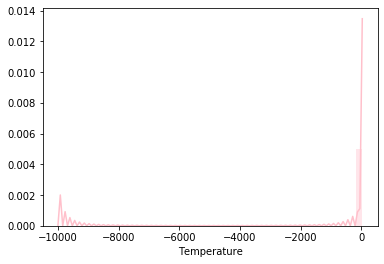

In [5]:
import seaborn as sns

# Showcase the distribution of tmperature data 
sns.distplot(df_temp.Temperature, hist=True, color = 'pink')


In [6]:
# Checking for highest temperature 
max(df_temp.Temperature)

29.9

The histogram shows us that the majoirty of the inputs is around 0 with highest at 29.9 C. However, there are some values on near -10000 celsius which is an imposible temperature input for our planet. Hence, we can check for anything below -100 and remove them as below that are erroneous observations. 

In [7]:
# Removing all the inputs lower than -100
df_temp = df_temp[df_temp.Temperature >= -100]
df_temp.head()

,Date,"Time: Hours, Minutes",Temperature
0,20110101.0,5.0,-6.4
1,20110101.0,10.0,-6.5
2,20110101.0,15.0,-6.5
3,20110101.0,20.0,-6.5
4,20110101.0,25.0,-6.7


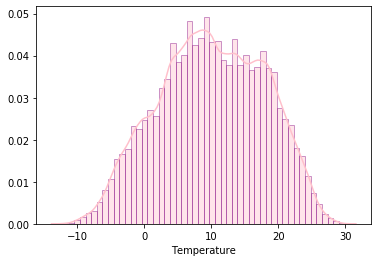

In [8]:
# Showing the distribution after droping the irregular inputs
sns.distplot(df_temp.Temperature, hist=True, color = 'pink', hist_kws={'edgecolor':'purple'})


In [9]:
# Double checking the lowest temp
min(df_temp.Temperature)

-12.1

### 1.3 Converting the dataset into a richer format whereby the day of the year is also captured => (ddd, mmm).

For example the time “20150212 1605”, can be converted into (43, 965) because the 12th of February is the 43rd day of the year, and 16:05 is the 965th minute of the day.

In [10]:
# Coverting the date data into datetime format 
df_temp.Date = pd.to_datetime(df_temp.Date, format = ('%Y%m%d'))
df_temp.head()

,Date,"Time: Hours, Minutes",Temperature
0,2011-01-01,5.0,-6.4
1,2011-01-01,10.0,-6.5
2,2011-01-01,15.0,-6.5
3,2011-01-01,20.0,-6.5
4,2011-01-01,25.0,-6.7


In [11]:
# Adding a column showcasing the number of days passed since start of the year 
df_temp['Day'] = df_temp.Date.dt.strftime('%j').astype(int)
df_temp.head()

,Date,"Time: Hours, Minutes",Temperature,Day
0,2011-01-01,5.0,-6.4,1
1,2011-01-01,10.0,-6.5,1
2,2011-01-01,15.0,-6.5,1
3,2011-01-01,20.0,-6.5,1
4,2011-01-01,25.0,-6.7,1


In [12]:
# Adding a column showcasing the number of minutes passed since start of the day
df_temp['Min'] = np.floor(df_temp['Time: Hours, Minutes']/100)*60 + np.mod(
    df_temp['Time: Hours, Minutes'], 100)
df_temp.head()


,Date,"Time: Hours, Minutes",Temperature,Day,Min
0,2011-01-01,5.0,-6.4,1,5.0
1,2011-01-01,10.0,-6.5,1,10.0
2,2011-01-01,15.0,-6.5,1,15.0
3,2011-01-01,20.0,-6.5,1,20.0
4,2011-01-01,25.0,-6.7,1,25.0


In [13]:
# Adding a column showing only the year 
df_temp['Year'] = df_temp['Date'].dt.year
df_temp.tail()

,Date,"Time: Hours, Minutes",Temperature,Day,Min,Year
631291,2016-12-31,2340.0,0.3,366,1420.0,2016
631292,2016-12-31,2345.0,0.2,366,1425.0,2016
631293,2016-12-31,2350.0,0.0,366,1430.0,2016
631294,2016-12-31,2355.0,-0.1,366,1435.0,2016
631295,2017-01-01,0.0,-0.1,1,0.0,2017


## Step 2. Splitting data into training and test set

This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.

In [14]:
# Creating a split point at 2016 
split = np.where(np.logical_and(df_temp.Date == '2016-01-01 00:00:00' , df_temp.Min == 0))[0][0]

# Splitting into train and test data
train = df_temp.iloc[:split]
test = df_temp.iloc[split:]

# Converting train and test dataframe values into arrays
train = train.values 
test = test.values

As we will be training model on daily, yearly and fully components, we need to split data into those components. 

In [15]:
# Creating training dataset for each component of the dataset 
train_temp = np.array(train[:, 2])
train_days = np.array(train[:, 3])
train_mins = np.array(train[:, 4])


# Creating testing dataset for each component of the dataset 
test_temp = np.array(test[:, 2])
test_days = np.array(test[:, 3])
test_mins = np.array(test[:, 4])


In [16]:
# Transforming all data sets into columns from rows
train_temp, test_temp = train_temp.reshape(-1,1), test_temp.reshape(-1,1)
train_mins, test_mins = train_mins.reshape(-1,1), test_mins.reshape(-1,1)
train_days, test_days = train_days.reshape(-1,1), test_days.reshape(-1,1)

# Getting all the values for mins, days and years
mins = df_temp['Min'].values.reshape(-1, 1)
days = df_temp['Day'].values.reshape(-1, 1)

## Step 3. Cover each input dimension with a list of radial basis functions.

This turns the pair of inputs into a much richer representation, mapping (d,t) into (Φ₁(d), Φ₂(t)). Here, I experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions.


In the case of RBF kernels, except the parameter c, there is one more to fine-tune, the sigma parameter (σ) (bandwidth of kernel function). This parameter controls the level of non-linearity introduced in the model. If the sigma value is very small, then the decision boundary is highly non-linear.

### 3.1.  Defining all the needed functions to  build a linear parameter model that captures both seasonal variations and daily variations.

In [62]:
def r2(train_x, train_y, test_x=[], test_y=[], test=False):
    """
        Function calculates R² for a given model based on the training and test data.
    """
    # Using 10-fold cross-validation to avoid overfitting as we have big dataset 
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # Defining the model and automatically picking best alpha 
    regression_model = RidgeCV(alphas= np.arange(0, 1, 0.01), cv=cv, fit_intercept=False)
    regression_model.fit(train_x, train_y)
    
    if test:
        return regression_model.score(train_x, train_y), regression_model.score(test_x, test_y)
    else:
        return regression_model.score(train_x, train_y)

def centers_min(num):
    """
        Function creates n number for the RBF by dividing the range of minutes of the 
        day into same distances.
    """
    # Return reshaped the list of centers as columns
    return np.linspace(0, 1440, num).reshape(-1,1)

def centers_days(num):
    """
        Function creates n number for the RBF by dividing the range of the day of the 
        year into same distances.
    """
    # Return reshaped the list of centers as columns
    return np.linspace(0, 366, num).reshape(-1,1)

def RBF(x_axis, centers, bandwidth):
    """
        Function returns RBF based on different numbers of radial basis functions and
        different bandwidths of the radial basis function in different dimensions.
    """
    rbf_results = rbf_kernel(x_axis, centers, gamma=1.0/bandwidth)
    
    return rbf_results


### 3.2. Daily variations without RBF cover.

In [18]:
# Setting pre-split data to train and test sets
x_train = train_mins
y_train = train_temp

# Setting the model 
regr = LinearRegression()
regr.fit(train_mins, train_temp)

x_plot = [[0], [1435]]
y_predict = regr.predict(x_plot)

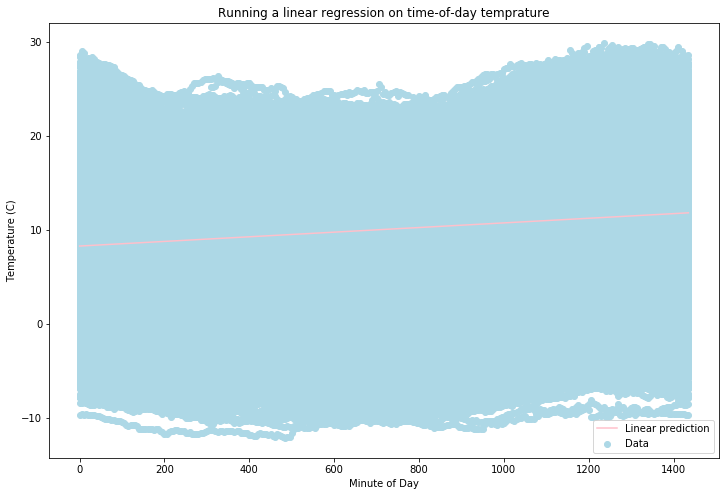

In [69]:
# Plotting the linear parameter model for time-of-day contributions 
plt.figure(figsize=(12,8))
plt.scatter(train_mins, train_temp, label='Data', color='lightblue')
plt.plot(x_plot, y_predict, label='Linear prediction', color='pink')
plt.legend(loc='best')
plt.title("Running a linear regression on time-of-day temprature")
plt.xlabel("Minute of Day")
plt.ylabel("Temperature (C)")
plt.show()

In [19]:
# Looking into R^2 error before covering each input dimension with a list of radial basis functions
print (f"R^2 for training mins data without RBF: {round(regr.score(x_train, y_train),4)}")
print (f"R^2 for testing mins data without RBF: {round(regr.score(test_mins, test_temp),4)}")


R^2 for training mins data without RBF: 0.0171
R^2 for testing mins data without RBF: 0.0178


### 3.3. Daily variations with RBF cover.

In [20]:
mins_centers = 10
mins_bandwidth = 50

# Covering each input dimension with a list of radial basis functions
rbf_train_mins = RBF(train_mins, centers_min(mins_centers), mins_bandwidth)
rbf_test_mins = RBF(test_mins, centers_min(mins_centers), mins_bandwidth)

# Setting the model 
# regr = Ridge(alpha=0.0001, fit_intercept=False)
regr = LinearRegression()
regr.fit(rbf_train_mins, train_temp)
y_predict_test = regr.predict(rbf_test_mins)
y_pred_train = regr.predict(rbf_train_mins)



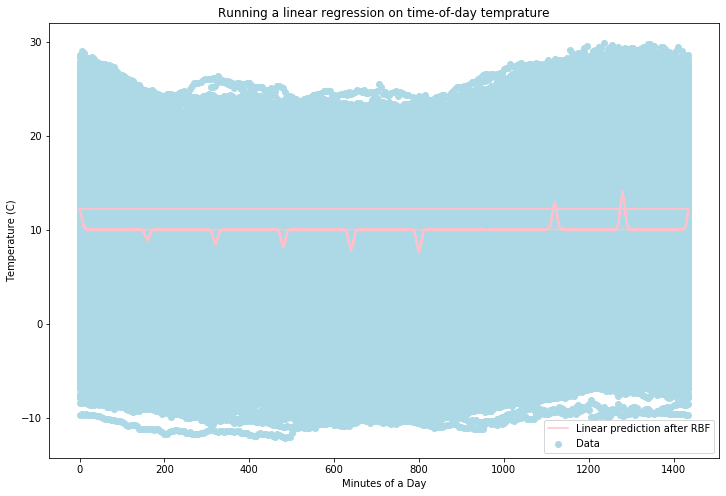

In [75]:
# Plotting the RBF-applied linear parameter model for time-of-day contributions 
plt.figure(figsize=(12,8))
plt.scatter(train_mins, train_temp, label='Data', color='lightblue')
plt.plot(test_mins, y_predict_test, label='Linear prediction after RBF', color='pink')
plt.legend(loc='best')
plt.title("Running a linear regression on time-of-day temprature")
plt.xlabel("Minutes of a Day")
plt.ylabel("Temperature (C)")
plt.show()

In [21]:
from sklearn.metrics import r2_score
# Looking into R^2 error after covering each input dimension with a list of radial basis functions
print(f"R^2 for training mins data with RBF: {round(r2_score(train_temp, y_pred_train),4)}")
print(f"R^2 for testing mins data with RBF: {round(r2_score(test_temp, y_predict_test),4)}")


R^2 for training mins data with RBF: 0.005
R^2 for testing mins data with RBF: 0.0048


### 3.4. Seasonal changes model without RBF cover.

In [22]:
# Setting the model 
regr = LinearRegression()
regr.fit(train_days, train_temp)

x_plot = [[0], [366]]
y_predict = regr.predict(x_plot)

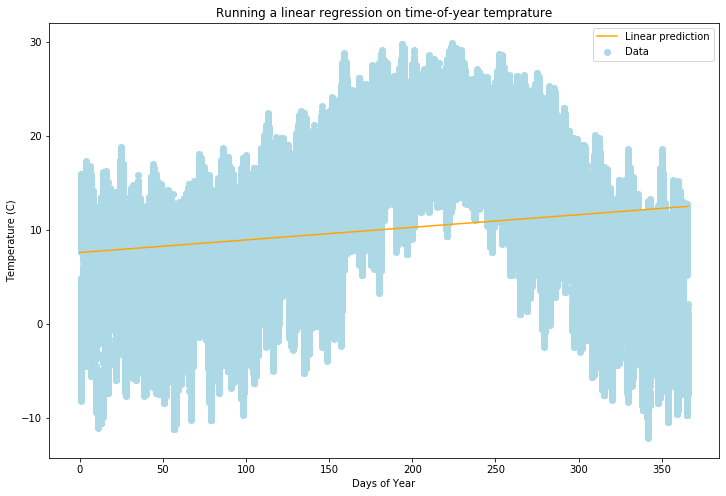

In [78]:
# Plotting the linear parameter model for time-of-year contributions 
plt.figure(figsize=(12,8))
plt.scatter(train_days, train_temp, label='Data', color='lightblue')
plt.plot(x_plot, y_predict, label='Linear prediction', color='orange')
plt.legend(loc='best')
plt.title("Running a linear regression on time-of-year temprature")
plt.xlabel("Days of Year")
plt.ylabel("Temperature (C)")
plt.show()

In [23]:
# Looking into R^2 error before covering each input dimension with a list of radial basis functions
print(f"R^2 for training days data without RBF: {round(regr.score(train_days, train_temp),4)}")
print(f"R^2 for testing days data without RBF: {round(regr.score(test_days, test_temp),4)}")



R^2 for training days data without RBF: 0.0326
R^2 for testing days data without RBF: 0.0409


### 3.5. Seasonal changes model with RBF cover.

In [24]:
days_centers = 5
days_bandwidth = 10

# Covering each input dimension with a list of radial basis functions
rbf_train_days = RBF(train_days, centers_days(days_centers), days_bandwidth)
rbf_test_days = RBF(test_days, centers_days(days_centers), days_bandwidth)

# Setting the model 
# regr = Ridge(alpha=0.0001, fit_intercept=False)
regr = LinearRegression()
regr.fit(rbf_train_days, train_temp)

y_predict_train = regr.predict(rbf_train_days)
y_predict_test = regr.predict(rbf_test_days)

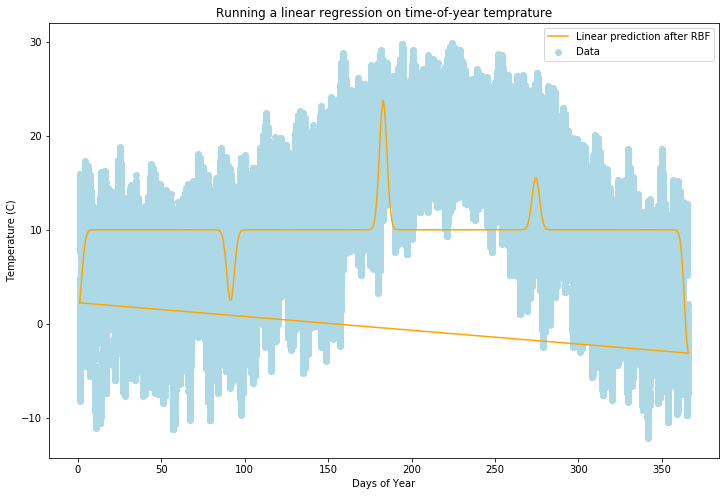

In [85]:
# Plotting the RBF-applied linear parameter model for time-of-year contributions 
plt.figure(figsize=(12,8))
plt.scatter(train_days, train_temp, label='Data', color='lightblue')
plt.plot(test_days, y_predict_test, label='Linear prediction after RBF', color='orange')
plt.legend(loc='best')
plt.title("Running a linear regression on time-of-year temprature")
plt.xlabel("Days of Year")
plt.ylabel("Temperature (C)")
plt.show()

In [25]:
# Looking into R^2 error after covering each input dimension with a list of radial basis functions
print (f"R^2 for training days data with RBF: {round(r2_score(train_temp, y_predict_train),4)}")
print (f"R^2 for testing days data with RBF: {round(r2_score(test_temp, y_predict_test),4)}")



R^2 for training days data with RBF: 0.0674
R^2 for testing days data with RBF: 0.0649


## Step 4. Experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions.

In [59]:
# This code piece took me 3+ hours, so think twice before running it
# Generating different center numbers between between 1 and 50
center_n = [1, 10, 50]
# Placeholders for the centers 
center_mins = []
center_days = []

# Calculate the centers for mins and days
for c in center_n:
    center_mins.append(centers_min(c))
    
for c in center_n:
    center_days.append(centers_days(c))
        
# Creating a list of various bandwidth points
bandwidths = np.array([1, 10, 100, 1000])

# Placeholder for R2 results
output = []


for center in center_mins:
    for bandwidth in bandwidths:
        
        x_axis_train = RBF(train_mins, center, bandwidth)
        x_axis_test = RBF(test_mins, center, bandwidth)

        r2_mins_train, r2_mins_test = r2(x_axis_train, train_temp, x_axis_test, test_temp, test=True)       
    
for center in center_days:
    for bandwidth in bandwidths:
        x_axis_train = RBF(train_days, center, bandwidth)
        x_axis_test = RBF(test_days, center, bandwidth)

        r2_days_train, r2_days_test = r2(x_axis_train, train_temp, x_axis_test, test_temp, test=True)
    
                
output.append([len(center), bandwidth, r2_full_test, r2_full_train, r2_days_test,r2_days_train, r2_mins_train, r2_mins_test])


# Shocase the error outputs
results = pd.DataFrame(output, columns=['Centers Num.", "Bandwidth", "Full Model Test R^2",  "Full Model Train R^2", 
                                 "Days Testing R^2", "Days Training R^2", "Mins Testing R^2", "Mins Training R^2"])
results.head(18)

,Centers Num.,Bandwidth,Full Model Test R^2,Full Model Train R^2,Days Testing R^2,Days Training R^2,Mins Testing R^2,Mins Training R^2
0,1,0.1,0.005837,0.005166,0.005662,0.005007,0.000175,0.000044
1,1,1.0,0.009409,0.006280,0.009047,0.005949,0.000363,0.000216
2,1,10.0,0.020786,0.016530,0.020396,0.016173,0.000390,0.000242
3,1,100.0,0.052691,0.078698,0.051786,0.077858,0.000905,0.000723
4,1,1000.0,0.161596,0.241109,0.158683,0.238406,0.002911,0.002578
5,1,10000.0,0.399139,0.479676,0.389047,0.470270,0.010075,0.009320
6,10,0.1,0.018599,0.034018,0.017568,0.033268,0.001052,0.000905
7,10,1.0,0.043408,0.074377,0.041861,0.072816,0.001548,0.001446
8,10,10.0,0.134682,0.188252,0.132252,0.185783,0.002430,0.002356
9,10,100.0,0.399063,0.435751,0.391726,0.428364,0.007328,0.007276


This table shows a general trend of the proportional increase of the number of RBF centres, bandwidth and the $R^2$ score. However, we also see that the training score decreases as the testing score increases. Even with a slight difference, this can indicate overfitting of our model, which limits its functionality of predicting the weather for new dates. Hence, we pick bandwidth to be 10000 while the number of centres to be ten as at those values the model has highest $R^2$ while also having test score to be lower than train score for all three model variations (full, seasonal, and daily).

## Step 5. Using RBF representation, build a linear parameter model that captures both seasonal variations and daily variations.

In [79]:
# Best seasonal changes model 
best_days_train = RBF(train_days, centers_days(10), 10000)
best_days_test = RBF(test_days, centers_days(10), 10000)

regr = Ridge(alpha=0.0001, fit_intercept=False)
regr.fit(best_days_train, train_temp)
y_pred = regr.predict(best_days_train)

# plt.scatter(train_days, train_temp, label='Data', color='b')
# plt.scatter(train_days, y_pred, label='Model Prediction', color='m')
# plt.legend(loc='best')
# plt.title("Running a linear regression on time-of-year temprature")
# plt.xlabel("Days of Year")
# plt.ylabel("Temperature (C)")
# plt.show()

print (f"R^2 for seasonal training data: {round(regr.score(best_days_train, train_temp),4)}")
print (f"R^2 for seasonal testing data : {round(regr.score(best_days_test, test_temp),4)}")


R^2 for seasonal training data: 0.5676
R^2 for seasonal testing data : 0.5785


In [80]:
# Best daily changes model 
best_mins_train = RBF(train_mins, centers_min(10), 10000)
best_mins_test = RBF(test_mins, centers_min(10), 10000)

regr = Ridge(alpha=0.0001, fit_intercept=False)
regr.fit(best_mins_train, train_temp)
y_pred = regr.predict(best_mins_train)

# plt.scatter(train_mins, train_temp, label='Data', color='b')
# plt.scatter(train_mins, y_pred, label='Model Prediction', color='m')
# plt.legend(loc='best')
# plt.title("Running a linear regression on time-of-day temprature")
# plt.xlabel("Minutes of a Day")
# plt.ylabel("Temperature (C)")
# plt.show()

print (f"R^2 for daily training data: {round (regr.score(best_mins_train, train_temp),4)}")
print (f"R^2 for daily testing data : {round (regr.score(best_mins_test, test_temp),4)}")


R^2 for daily training data: 0.043
R^2 for daily testing data : 0.0427


In [77]:
# Best full model 
full_train = pd.concat([pd.DataFrame(best_mins_train),
                          pd.DataFrame(best_days_train)], axis=1)

full_test = pd.concat([pd.DataFrame(best_mins_test),
                          pd.DataFrame(best_days_test)], axis=1)

regr = LinearRegression()
regr.fit(full_train, train_temp)

y_predict_train = regr.predict(full_train)
y_predict_test = regr.predict(full_test)

print (f"R^2 for training data: {round(r2_score(train_temp, y_predict_train),4)}")
print (f"R^2 for testing data: {round(r2_score(test_temp, y_predict_test),4)}")

R^2 for training data: 0.6139
R^2 for testing data: 0.6155


## Step 6. A 3D plot showing temperature as a function of (day, time).

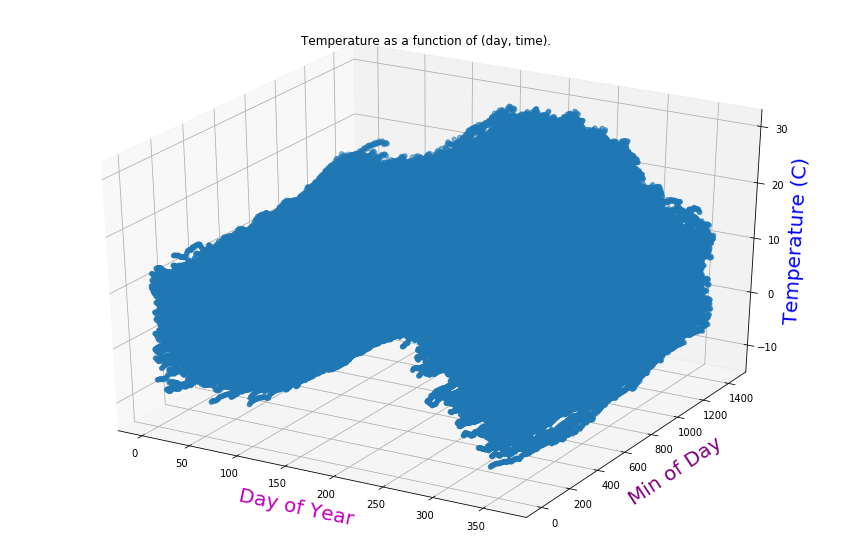

In [45]:
from mpl_toolkits.mplot3d import Axes3D 
plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.scatter3D(np.asarray(train_days, dtype = "float"), np.asarray(train_mins, dtype = "float"), np.asarray(train_temp, dtype = "float"), cmap='Pastel2')
plt.title("Temperature as a function of (day, time).")
ax.set_xlabel('Day of Year', fontsize=20, rotation=150, color = "m", labelpad=10)
ax.set_ylabel('Min of Day', fontsize=20, color = "purple", labelpad=10)
ax.set_zlabel('Temperature (C)', fontsize=20, rotation=60, color="blue")
plt.show()

There is too much data to show it beautifully in 3d.

## Step 7. Using R², quantifing how our model performs on the testing data.


With all three models, we see that before applying RBF, the test $R^2$ score is slightly more than the train $R^2$  score, indicating overfitting. After using RBF, the general scores increase and test scores are lower, which shows that we have addressed overfitting. 

Additionally, as the number of RBF centres increases, the $R^2$ score results for all models also increases, as shown in the table above. So, $R^2$  is highest when the num centres are 50 or more. But we see that there is an incidctaion to overfitting as test scores are slightly higher than train scores. hence, we pick num of centers to be 10 instead as results are very close to each other but at 10, the test score are lower than train scores. We see a similar pattern for observing the bandwidth (sigma) of the RBF. We have a minimum score for each variant of the models for lower values of bandwidth. However, as bandwidth increases with the number of centres, $R^2$ output increases. Hence, we pick highest bandwidth, 10000, and highest number of centers where test scores are lower than train scores, 10.




### 7.1 Train with just the daily component of the model

The daily model has the lowest values for $R^2$ scores. In real life, time-in-day variation doesn't, in general, predict the overall weather pattern, which explains those low scores. 


### 7.2 Train with just the yearly component of the model
The seasonal changes capture the dataset better, almost as good as the whole model. Hence, nearly half of the variance in the temperature can be explained by the seasonal variation.

### 7.3 Train with the full model
The whole set performed best in terms of $R^2$ test scores. This is logical as both seasonal and daily changes contribute to the temperature output. However, around 40% of the variance in temperature is still not explained even by the full dataset we analyzed. Hence, those models would suit general weather prediction but can be inaccurate for more precise weathercasts. Additionally, as we saw, picking right badnwidth (sigma) and number of RBF circles will be crucisial in improving the accuracy of a model and also making sure it doesn't overfit. 